### Ada_Boost_Implementation

Load data

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
# The second class vs others is the most difficult separation
y_bi = np.array([1 if label==1 else 0 for label in y])
y_bi

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [2]:
# define a function to compute the error rate of a model 
def compute_model_error(X, y, prediction, weights):
    error = np.sum((prediction != y) * weights)
    return error

In [3]:
from sklearn.linear_model import LogisticRegression

# define a fuction to instantiate a logistic regression model
def init_logistic_regression():
    return LogisticRegression()

In [4]:
# define a dictionary of name:model_init_function, then we can add more models later on
model_dict = {'LR':init_logistic_regression}

In [5]:
def ada_boost_train(X, y, k, classifier='LR'):
    d = len(X)
    # initialize the weight
    weights = np.array([1/d] * d)
    # create errors place holder for k models
    errors = np.ones(k)
    models = []
    for i in range(k):
        D_i = None
        y_i = None
        prediction = None
        sample_indices = None
        while (errors[i] > 0.5):
            # sample d with replacement based on weights
            sample_indices = np.random.choice(d, d, p=weights)
            # get train data and labels
            D_i = X[sample_indices]
            y_i = y[sample_indices]
            # instantiate a new model
            model = model_dict[classifier]()
            # fit with samples
            model.fit(D_i, y_i)
            # make predictions
            prediction = model.predict(D_i)
            # update error(Mi)
            errors[i] = compute_model_error(D_i, y_i, prediction, weights)
        # save the model
        models.append(model)
        # compute updating factor
        update_factor = errors[i] / (1 - errors[i])
        # for each sample in D_i with correctly classified, update the weight
        for index in sample_indices[prediction == y_i]:
            weights[index] = weights[index] * update_factor
        # normalize the weights
        weights = weights / np.linalg.norm(weights, ord=1)
    return models, errors   

In [6]:
def ada_boost_predict(X, models, errors):
    assert len(models) == len(errors)
    n_models = len(models)
    n_samples = len(X)
    # create weights of two classes for each data point, [n_samples, 2]
    weights = np.zeros((n_samples, 2))
    
    for i in range(n_models):
        # compute the weight of the classifier's vote
        weight_i = np.log((1 - errors[i]) / errors[i])
        # compute prediction for each sample using model i
        label = models[i].predict(X)
        # update the weight of the corresponding class for each sample
        weights[range(n_samples), label] += weight_i
    return np.argmax(weights, axis=1)

### Compare ensemble models with the single logistic regression model

In [7]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3)
acc_single = []
acc_adaboost = []
for train_index, test_index in kf.split(X, y_bi):
    X_train=X[train_index]
    y_train=y_bi[train_index]
    X_test=X[test_index]
    y_test=y_bi[test_index]
    # single model
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    predictions1 = clf.predict(X_test)
    acc1 = np.mean(predictions1 == y_test)
    acc_single.append(acc1)
    # adaBoost model
    models, errors = ada_boost_train(X_train, y_train, 20)
    predictions2 = ada_boost_predict(X_test, models, errors)
    acc2 = np.mean(predictions2 == y_test)
    acc_adaboost.append(acc2)
    
print('avg accuracy of single logistic regression and AdaBoost are', np.mean(acc_single), np.mean(acc_adaboost))

avg accuracy of single logistic regression and AdaBoost are 0.604817927171 0.630276110444


We can see that AdaBoost increased the accuracy.

### DBScan Implementation

In [12]:
# Define a function to compute the Euclidean distance between p vector and q vector
def compute_Euclidean_distance(p, q):
    return np.linalg.norm(p - q)

In [13]:
# This is a inner function of dbscan to find neighbors of p_data 
def get_eps_neighbors(data, p_data, dist_fun, eps=0.5):
    neighbors = []
    # search through all points in X
    for q_data in data:
        # compute distance between q and p
        q = q_data[:-3]
        p = p_data[:-3]
        if dist_fun(q, p) <= eps:
            neighbors.append(q_data.tolist())
    return np.array(neighbors)

In [14]:
def dbscan(X, dist_fun, eps=0.5, min_samples=5):
    # number of samples
    n_X = len(X)
    # create the "visited" marker (col 4) (1: visited, 0: not) and cluster labels (col 5)
    indicator = np.zeros((n_X, 2))
    # initialize to noise
    indicator[:, 1] = -1
    # stack into one data
    data = np.hstack((X, indicator))
    # add data index (col 6)
    data = np.hstack((data, np.array(range(n_X)).reshape(-1, 1)))
    
    unvistied_points_mask = (data[:, 4] == 0)
    # check unvisited
    has_unvisited = np.any(unvistied_points_mask)
    # initialize cluster label value
    cluster = -1
    while has_unvisited:

        # select unvisited points
        unvisited_points = data[unvistied_points_mask]
        # shuffle them and pick first one
        np.random.shuffle(unvisited_points)
        p = unvisited_points[0]
        # get index of p
        p_index = int(p[6])

        # update p as visited
        data[p_index, 4] = 1
        
        neighbors = get_eps_neighbors(data, p, dist_fun, eps)

        
        if len(neighbors) >= min_samples:
            # create a new cluster
            cluster += 1
            data[p_index, 5] = cluster
            
            while len(neighbors) > 0:
                # start from first one neighbor
                p_prime = neighbors[0]
                # get index of p_prime
                p_prime_index = int(p_prime[6])
                # if unvisited
                if p_prime[4] == 0:
                    # update p_prime as visited
                    p_prime[4] = 1
                    data[p_prime_index, 4] = 1
                    # get neighbors of p_prime
                    neighbors_p_prime = get_eps_neighbors(data, p_prime, dist_fun, eps)
#                     print(neighbors_p_prime)
                    if len(neighbors_p_prime) >= min_samples:
                        # get indices of neighbors of p_prime and add them to neighbors of p
                        neighbors_indices = list(set(neighbors[:, 6]).union(set(neighbors_p_prime[:, 6])))
                        neighbors_indices = [int(i) for i in neighbors_indices]
                        # update neighbors
                        neighbors = data[neighbors_indices]
                # if p_prime is not clustered
                if p_prime[5] < 0:
                    p_prime[5] = cluster
                    data[p_prime_index, 5] = cluster
                # remove current p_prime from neighbors of p    
                neighbors_indices = list(set(neighbors[:, 6]) - set([p_prime_index]))
                neighbors_indices = [int(i) for i in neighbors_indices]
                # update neighbors
                neighbors = data[neighbors_indices]
        else:
            p[5] = -1
            data[p_index, 5] = -1
        # update unvistied
        unvistied_points_mask = (data[:, 4] == 0)
        # check unvisited
        has_unvisited = np.any(unvistied_points_mask)
    
    return np.array([int(cluster_label) for cluster_label in data[:, 5].tolist()]) 

### Test it with sklearn implementation

In [15]:
from sklearn.cluster import DBSCAN

my_labels = dbscan(X, compute_Euclidean_distance, 0.5, 5)
dbscan_skl = DBSCAN(eps=0.5, min_samples=5)
dbscan_skl.fit(X)

print(np.sum(my_labels != dbscan_skl.labels_))

0


Looks good!

Compute each pair's distance in order to tune dbscan

In [16]:
dist_mat = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(i+1, len(X)):
        dist = compute_Euclidean_distance(X[i], X[j])
        dist_mat[i, j] = dist
        dist_mat[j, i] = dist

In [17]:
max_dist = np.max(dist_mat)
max_dist

7.0851958335673411

In [18]:
min_dist_except_zero = np.sort(list(set(dist_mat.flatten())))[1]
min_dist_except_zero

0.099999999999999645

Create param grid

In [19]:
import itertools

eps_list = np.linspace(0.1, 7, 20)
min_samples_list = list(range(5, 20))
dbscan_param_grid = list(itertools.product(eps_list, min_samples_list))

Choose the best param based on silhouette score

In [20]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm

silhouette_avgs = []
for param in tqdm(dbscan_param_grid):
    labels = dbscan(X, compute_Euclidean_distance, eps=param[0], min_samples=param[1])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    silhouette_avg = 0

    if n_clusters > 1:
        silhouette_avg = silhouette_score(X, labels)
    silhouette_avgs.append(silhouette_avg)

100%|██████████| 300/300 [01:33<00:00,  3.21it/s]


In [21]:
optimal_params = np.array(dbscan_param_grid)[np.argsort(silhouette_avgs)][-1]
optimal_params

array([  1.55263158,  19.        ])

Use the optimal parameters to retrain a model

In [22]:
dbscan_labels = dbscan(X, compute_Euclidean_distance, optimal_params[0], optimal_params[1])

### Compare with kmeans

Tune K

In [23]:
from sklearn.cluster import KMeans

silhouette_avgs = []
for k in tqdm(range(1, 4)):
    kmeans = KMeans(n_clusters=k).fit(X)
    labels = kmeans.labels_
    n_clusters = len(set(labels))
    silhouette_avg = 0

    if n_clusters > 1:
        silhouette_avg = silhouette_score(X, labels)
    silhouette_avgs.append(silhouette_avg)

100%|██████████| 3/3 [00:00<00:00, 41.70it/s]


In [24]:
optimal_k = np.array(range(1, 4))[np.argsort(silhouette_avgs)][-1]
optimal_k

2

In [25]:
kmeans = KMeans(n_clusters=optimal_k).fit(X)
kmeans_labels = kmeans.labels_

In [26]:
def color(s):
    if s==0:
        return 'red'
    elif s==1:
        return 'blue'
    elif s==2:
        return 'yellow'
    return 'black'

In [27]:
colors_correct = [color(label) for label in y_bi]
colors_dbscan = [color(label) for label in dbscan_labels]
colors_kmeans = [color(label) for label in kmeans_labels]

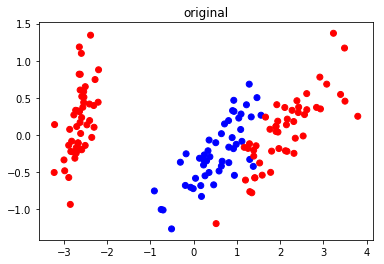

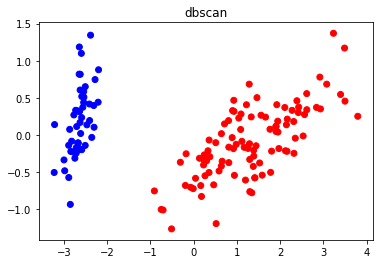

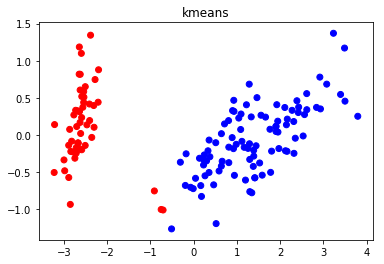

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_PCA = PCA(n_components=2).fit_transform(X)
plt.scatter(X_PCA[:,0], X_PCA[:,1],  c=colors_correct)
plt.title('original')
plt.show()

plt.scatter(X_PCA[:,0], X_PCA[:,1],  c=colors_dbscan)
plt.title('dbscan')
plt.show()

plt.scatter(X_PCA[:,0], X_PCA[:,1],  c=colors_kmeans)
plt.title('kmeans')
plt.show()

Looks like dbscan is better for the binary case.

Let's look at 3 classes case

In [30]:
param_list = []

for param in tqdm(dbscan_param_grid):
    labels = dbscan(X, compute_Euclidean_distance, eps=param[0], min_samples=param[1])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 2:
        param_list.append(param)

100%|██████████| 300/300 [01:35<00:00,  3.15it/s]


In [31]:
param_list

[(0.4631578947368421, 10)]

In [32]:
dbscan_labels = dbscan(X, compute_Euclidean_distance, eps=param_list[0][0], min_samples=param_list[0][1])

In [33]:
kmeans = KMeans(n_clusters=3).fit(X)
kmeans_labels = kmeans.labels_

In [34]:
colors_correct = [color(label) for label in y]
colors_dbscan = [color(label) for label in dbscan_labels]
colors_kmeans = [color(label) for label in kmeans_labels]

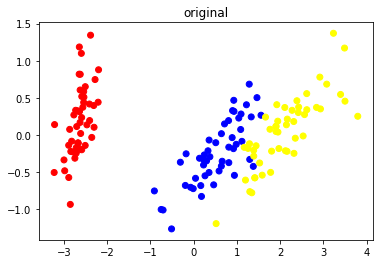

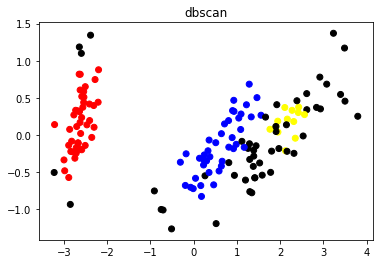

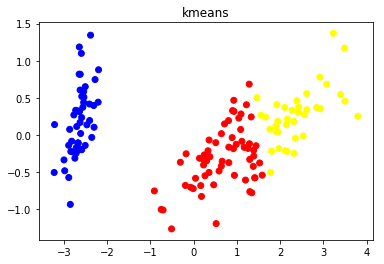

In [35]:
plt.scatter(X_PCA[:,0], X_PCA[:,1],  c=colors_correct)
plt.title('original')
plt.show()

plt.scatter(X_PCA[:,0], X_PCA[:,1],  c=colors_dbscan)
plt.title('dbscan')
plt.show()

plt.scatter(X_PCA[:,0], X_PCA[:,1],  c=colors_kmeans)
plt.title('kmeans')
plt.show()

We can see that in 3 classes case, dbscan does a worse job since it classify many points as the noise (black spots)